# RA Task - XiaoyuOuyang

# Pull papers after 2000

The objective of the following section is to generate a representative sample of academic papers emanating from the MIT Computer Science and Artificial Intelligence Lab. Specifically, papers published after 2000 are considered for inclusion. A web scraping methodology is employed to gather pertinent information from each paper, such as the title, year of publication, authors, keywords, and abstracts. This procedure entails extracting data from every paper on each webpage and subsequently navigating through the ensuing pages to retrieve additional papers. To ensure that the final dataset encapsulates a span from 2000 to 2023, a random subset of 400 papers is chosen from the complete dataset, which is then exported in CSV format for further analysis.

In [62]:
# Import packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import warnings
import time
import scrapy
import random
warnings.filterwarnings("ignore")

In [32]:
def scrape_current_page(soup):
    """
    Scrape data of papers on current page with input of page html "soup" and return "df"
    
    soup: html document of current page
    df: dataframe including title, year, author, link, keyword, abstract of all papers on current page
    """
    
    # Initialize df
    df = pd.DataFrame(columns = ["title", "year", "author", "link", "keyword", "abstract"])
    paper_tags = soup.find_all("div", class_="artifact-description")
    
    # Find date, title, link, author, keyword of each paper 
    for paper in paper_tags:
        date = paper.find("span", class_ = "date")
        if date == None:
            continue
        try:
            # Extract year of issue date
            year = int(date.text[:4])
        except:
            continue
            
        title = paper.find("a").text
        link = paper.find("a", href=True)["href"]
        author = [x.text for x in paper.find_all("span", class_= "ds-dc_contributor_author-authority")]
        
        # Find url of the specific page of paper
        url = "https://dspace.mit.edu"+link
        
        # Test if scrapping is blocked due to too many requests
        while True:
            page = requests.get(url, headers = headers)
            soup = BeautifulSoup(page.content, "lxml")
            if not is_error_429(soup):
                break
            else:
                print(title, ': Too many request, attempt ', attempt_count, ' failed')
        
        # Try to find keyword 
        try:
            keyword = soup.find("div", class_ = "simple-item-view-subject item-page-field-wrapper").find("div").text
        except:
            continue
        
        # Try to find abstract
        try:
            abstract = soup.find("div", class_ = "simple-item-view-description item-page-field-wrapper table").find("div").text
        except:
            continue
        
        # Fill in the dataframe
        df_temp = {'title': title, 'year': year, 'author': author, "link": link, "keyword": keyword, "abstract": abstract}
        df = df.append(df_temp, ignore_index = True)

    return df

In [30]:
def next_page(soup):
    """
    Get html of the next page "nextsoup" given html of the current page "soup"
    
    soup: html of current page
    nextsoup: html of next page
    """
    
    # Find link to the next page
    nextlink = soup.find("a", class_= "next-page-link")["href"]
    
    # Check if there is a next page and return html of next page if exists
    if nextlink is not "":
        print("Have next page.")
        nextpage = requests.get("https://dspace.mit.edu/handle/1721.1/5458/"+nextlink, headers = headers)
        nextsoup = BeautifulSoup(nextpage.content, "lxml")
        return nextsoup
    
    else:
        print("No next page!")
        return None

In [31]:
def is_error_429(soup):
    """
    Detect error of too many requests to a html
    """
    if soup.find('title').text == 'HTTP Status 429 – Too Many Requests':
        return True
    return False

In [44]:
if __name__ == '__main__':
    
    # Use headers to avoid being blocked
    headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
        }

    # Scrape the first page showing papers after 2000 in ascending order of date (each page has 20 papers)
    URL = "https://dspace.mit.edu/handle/1721.1/5458/browse?rpp=20&etal=-1&sort_by=2&type=dateissued&starts_with=2000&order=ASC"
    page = requests.get(URL, headers = headers)
    soup = BeautifulSoup(page.content, "lxml")
    df = scrape_current_page(soup)
    
    # Scrape all papers after 2000 until there is no next page
    while True:
        soup = next_page(soup)
        if soup is None: 
            break
        newdf = scrape_current_page(soup)
        df = df.append(newdf, ignore_index=True)
        print(f"{df.shape[0]} papers have been scrapped.")
        print("---------------------------------------------------------")

Have next page.
2 papers have been scrapped.
---------------------------------------------------------
Have next page.
6 papers have been scrapped.
---------------------------------------------------------
Have next page.
20 papers have been scrapped.
---------------------------------------------------------
Have next page.
37 papers have been scrapped.
---------------------------------------------------------
Have next page.
43 papers have been scrapped.
---------------------------------------------------------
Have next page.
52 papers have been scrapped.
---------------------------------------------------------
Have next page.
60 papers have been scrapped.
---------------------------------------------------------
Have next page.
69 papers have been scrapped.
---------------------------------------------------------
Have next page.
78 papers have been scrapped.
---------------------------------------------------------
Have next page.
86 papers have been scrapped.
--------------------

In [52]:
# Randomly select 400 papers from 569 papers and export dataframe as a csv file
random_rows = random.sample(range(df.shape[0]), 400)
df_export = df.loc[random_rows].sort_values(by = "year").reset_index(drop = True)
df_export.to_csv("papers_after2000.csv")

In [53]:
df_export

,title,year,author,link,keyword,abstract
0,A Trainable System for Object Detection in Ima...,2000,"[Papageorgiou, Constantine P.]",/handle/1721.1/5566,"AI, MIT, Artificial Intelligence, object detec...","This thesis presents a general, trainable sys..."
1,A Note on the Generalization Performance of Ke...,2000,"[Evgeniou, Theodoros, Pontil, Massimiliano]",/handle/1721.1/7169,"AI, MIT, Artificial Intelligence, missing data...",We present distribution independent bounds on ...
2,Experimental Markets for Product Concepts,2001,"[Chan, Nicholas T., Dahan, Ely, Lo, Andrew W.,...",/handle/1721.1/7233,AI,Market prices are well known to efficiently co...
3,How do Humans Determine Reflectance Properties...,2001,"[Fleming, Roland W., Dror, Ron O., Adelson, Ed...",/handle/1721.1/6663,"AI, illumination, reflectance, natural image s...","Under normal viewing conditions, humans find i..."
4,Surface Reflectance Estimation and Natural Ill...,2001,"[Dror, Ron O., Adelson, Edward H., Willsky, Al...",/handle/1721.1/6656,"AI, reflectance, lighting, BRDF, surface, illu...",Humans recognize optical reflectance propertie...
...,...,...,...,...,...,...
395,Comprehensive Java Metadata Tracking for Attac...,2019,"[Perkins, Jeff, Eikenberry, Jordan, Coglio, Al...",/handle/1721.1/122969,"security, runtime instrumentation, numeric err...","We present ClearTrack, a system that tracks 32..."
396,Bucket Elimination Algorithm for Dynamic Contr...,2021,"[Zhang, Yuening]",/handle/1721.1/130057,"temporal networks, dynamic controllability, bu...",Simple Temporal Networks with Uncertainty (STN...
397,Neurosymbolic Programming for Science,2022,"[Sun, Jennifer J, Tjandrasuwita, Megan, Sehgal...",/handle/1721.1/145783,"programming languages, deep learning, science,...",Neurosymbolic Programming (NP) techniques have...
398,Universal Motion Generator: Trajectory Autocom...,2022,"[Wang, Yanwei, Shah, Julie]",/handle/1721.1/143430,"Robot Learning, Large Language Models, Motion ...","Foundation models, which are large neural netw..."


# Categorize ethnicity of authors

In order to determine the ethnicity of the authors, the full name of each author was first divided into a first name and a last name. Authors with incomplete names were excluded from further analysis. Due to the lack of reliable information sources regarding the nationality or ethnicity of the authors, a Python package known as "ethnicolr" was utilized to predict the authors' most probable ethnicities. The "pred_fl_reg_name" function within the package, which employs the full-name FL model, was specifically utilized to provide mean, standard error, lower and upper bounds of the confidence interval for each race. Ultimately, a pie chart was created to depict the proportion of authors from different ethnic groups among the 400 papers in the dataset.

In [597]:
import matplotlib.pyplot as plt
from ethnicolr import pred_fl_reg_name
import seaborn as sns
sns.set_palette("Set2")

In [416]:
# Create a copy of df_export dataframe
df = df_export.copy()

# Store names of all authors into a list
author_list = []
for authors in df["author"]:
    for author in authors:
        author_list.append(author)

# Create a dataframe consisting of authors' full, first, last names
author_df = pd.DataFrame(data ={"author":list(set(author_list))})
for i in range(author_df.shape[0]):
    try:
        author_df.loc[i, "last"], author_df.loc[i, "first"]  = author_df.loc[i, "author"].split(",")[0], author_df.loc[i, "author"].split(",")[1]
    except:
        name = author_df.loc[i, "author"]
        print(f"Author of incomplete name: {name}")

Author of incomplete name: Sinha
Author of incomplete name: Jarudi
Author of incomplete name: Riesenhuber
Author of incomplete name: Gilad


In [417]:
# Use "ethnicolr" to predict ethnicity
odf = pred_fl_reg_name(author_df, "last", "first", conf_int=0.9)[["author", "last", "first", "race"]]
odf["race"] = odf["race"].apply(lambda x: x.replace("nh_white", "white").replace("nh_black", "black"))
odf

['asian', 'hispanic', 'nh_black', 'nh_white']


,author,last,first,race
0,"Khan, Omer",Khan,Omer,asian
1,"Kemp, Charles",Kemp,Charles,white
2,"Radul, Alexey",Radul,Alexey,white
3,"Leonard, John",Leonard,John,white
4,"Wang, Xiaogang",Wang,Xiaogang,asian
5,"Tacchetti, Andrea",Tacchetti,Andrea,white
6,"Ho, Tracy",Ho,Tracy,asian
7,"Wormald, Nicholas",Wormald,Nicholas,white
8,"Shah, Neel",Shah,Neel,asian
9,"Rohanimanesh, Khashayar",Rohanimanesh,Khashayar,black


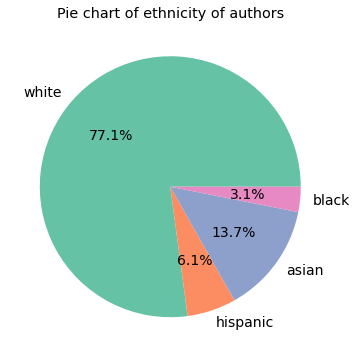

In [794]:
# Draw a pie chart with percentage of authors with different ethnicities
plt.figure(figsize=(6, 6))

race_list = list(odf["race"])
sizes = [race_list.count("white"), race_list.count("hispanic"), race_list.count("asian"), race_list.count("black")]
labels = "white", "hispanic", "asian", "black"
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', textprops={'fontsize': 14})
plt.title("Pie chart of ethnicity of authors")

plt.show()

# Categorize Research Topics

In [728]:
# Create a copy of df_export dataframe
df = df_export.copy()[["title", "year", "author","keyword", "abstract"]]

# Change keywords to lower case
df["keyword"] = df["keyword"].apply(lambda x: x.lower())
df

,title,year,author,keyword,abstract
0,A Trainable System for Object Detection in Ima...,2000,"[Papageorgiou, Constantine P.]","ai, mit, artificial intelligence, object detec...","This thesis presents a general, trainable sys..."
1,A Note on the Generalization Performance of Ke...,2000,"[Evgeniou, Theodoros, Pontil, Massimiliano]","ai, mit, artificial intelligence, missing data...",We present distribution independent bounds on ...
2,Experimental Markets for Product Concepts,2001,"[Chan, Nicholas T., Dahan, Ely, Lo, Andrew W.,...",ai,Market prices are well known to efficiently co...
3,How do Humans Determine Reflectance Properties...,2001,"[Fleming, Roland W., Dror, Ron O., Adelson, Ed...","ai, illumination, reflectance, natural image s...","Under normal viewing conditions, humans find i..."
4,Surface Reflectance Estimation and Natural Ill...,2001,"[Dror, Ron O., Adelson, Edward H., Willsky, Al...","ai, reflectance, lighting, brdf, surface, illu...",Humans recognize optical reflectance propertie...
5,Role of color in face recognition,2001,"[Yip, Andrew, Sinha, Pawan]","ai, face recognition, color, low-resolution, g...",One of the key challenges in face perception l...
6,Multiclass Classification of SRBCTs,2001,"[Yeo, Gene, Poggio, Tomaso]","ai, multiclass, svm, feature selection, srbct,...",A novel approach to multiclass tumor classific...
7,Range Segmentation Using Visibility Constraints,2001,"[Taycher, Leonid, Darrell, Trevor]",ai,Visibility constraints can aid the segmentatio...
8,Type-omega DPLs,2001,"[Arkoudas, Konstantine]","ai, deduction, computation, proof search, soun...",Type-omega DPLs (Denotational Proof Languages)...
9,An Algorithm for Bootstrapping Communications,2001,"[Beal, Jacob]","ai, adaptive learning hash-coding communicatio...",I present an algorithm which allows two agents...


In [729]:
# Find the most common 200 keywords 
from collections import Counter
kw = []
for i in range(df.shape[0]):
    try:
        keyword_list = [x.strip(" ") for x in df.loc[i, "keyword"].split(",")]
        df.at[i, "keyword"] = keyword_list
    except:
        pass
    for keyword in keyword_list:
        kw.append(keyword)
Counter = Counter(kw)
most_occur_keyword = Counter.most_common(200)

In [730]:
# Use chatgpt to assign each keyword to one of 16 subcategories of AI with manual adjustment
word_dict = {
    'object recognition': 'Computer Vision',
    'vision': 'Computer Vision',
    'machine learning': 'Machine Learning',
    'security': 'Security and Privacy',
    'context': 'Other',
    'robotics': 'Robotics',
    'wireless networks': 'Wireless Networks',
    'computer vision': 'Computer Vision',
    'classification': 'Machine Learning',
    'amorphous computing': 'Other',
    'learning': 'Machine Learning',
    'privacy': 'Security and Privacy',
    'multicore': 'Other',
    'multi-objective optimization': 'Optimization',
    'object detection': 'Computer Vision',
    'reinforcement learning': 'Machine Learning',
    'graphical models': 'Machine Learning',
    'hmax': 'Other',
    'face recognition': 'Recognition',
    'recognition': 'Recognition',
    'visual cortex': 'Neuroscience',
    'attention': 'Neuroscience',
    'neuroscience': 'Neuroscience',
    'decision making': 'Autonomous Vehicles',
    'learning theory': 'Theory',
    'uuv': 'Autonomous Vehicles',
    'usv': 'Autonomous Vehicles',
    'unmanned surface vehicles': 'Autonomous Vehicles',
    'moos': 'Distributed Systems',
    'computational learning': 'Machine Learning',
    'illumination': 'Computer Vision',
    'reflectance': 'Computer Vision',
    'svm': 'Machine Learning',
    'computation': 'Other',
    'invariance': 'Computer Vision',
    'regularization': 'Optimization',
    'natural language processing': 'Natural Language Processing',
    'distributed systems': 'Distributed Systems',
    'resilient mechanism design': 'Optimization',
    'unmanned marine vehicles': 'Autonomous Vehicles',
    'natural image statistics': 'Computer Vision',
    'scene recognition': 'Computer Vision',
    'registration': 'Computer Vision',
    'autonomy': 'Autonomous Vehicles',
    'online learning': 'Machine Learning',
    'wireless': 'Wireless Networks',
    'features': 'Computer Vision',
    'image retrieval': 'Computer Vision',
    'local descriptor': 'Computer Vision',
    'action selection': 'Autonomous Vehicles',
    'categorization': 'Machine Learning',
    'inferior temporal cortex': 'Neuroscience',
    'theory': 'Theory',
    'ventral stream': 'Neuroscience',
    'localization': 'Computer Vision',
    'path planning': 'Autonomous Vehicles',
    'network coding': 'Distributed Systems',
    'educational technology': 'Education',
    'confidentiality': 'Security and Privacy',
    'software radios': 'Wireless Networks',
    'kernel methods': 'Machine Learning',
    'computer graphics': 'Graphics',
    'dynamic analysis': 'Other',
    'unmanned vehicles': 'Autonomous Vehicles',
    'autonomous marine vehicles': 'Autonomous Vehicles',
    'autonomous vehicles': 'Autonomous Vehicles',
    'auv': 'Autonomous Vehicles',
    'moosdb': 'Distributed Systems',
    'autonomous helm': 'Autonomous Vehicles',
    'behaviors': 'Autonomous Vehicles',
    'phelmivp': 'Other',
    'autonomic computing': 'Other',
    'marine autonomy': 'Autonomous Vehicles',
    'scheduling': 'Other',
    'mit': 'Other',
    'pattern recognition': 'Computer Vision',
    'face detection': 'Computer Vision',
    'support vector machine': 'Machine Learning',
    'statistical learning theory': 'Machine Learning',
    'brdf': 'Graphics',
    'natural images': 'Computer Vision',
    'feature selection': 'Machine Learning',
    'deduction': 'Other',
    'soundness': 'Other',
    'logic': 'Other',
    'market-making': 'Other',
    'scene representation': 'Computer Vision',
    'optical flow': 'Computer Vision',
    'stereo': 'Computer Vision',
    'pose estimation': 'Computer Vision',
    'belief propagation': 'Machine Learning',
    'action recognition': 'Computer Vision',
    'identification': 'Recognition',
    'synchronization': 'Distributed Systems',
    'stability': 'Other',
    'reasoning': 'Other',
    'multimodal': 'Other',
    'segmentation': 'Computer Vision',
    'ad-hoc networks distributed algorithms atomic distributed shared memory': 'Distributed Systems',
    'pedestrian': 'Robotics',
    'walking direction': 'Robotics',
    'human motion': 'Robotics',
    'genetic programming': 'Machine Learning',
    'search': 'Other',
    'component object recognition': 'Computer Vision',
    'natural language': 'Natural Language Processing',
    'shape tuning': 'Graphics',
    'shape representation': 'Graphics',
    'gratings': 'Graphics',
    'v4': 'Neuroscience',
    'contour matching': 'Computer Vision',
    'shape matching': 'Computer Vision',
    'emd': 'Computer Vision',
    'pervasive computing': 'Other',
    'multi-agent learning': 'Machine Learning',
    'ad-hoc networking': 'Wireless Networks',
    'steerable filter': 'Computer Vision',
    'gaussian derivatives': 'Computer Vision',
    'selectivity': 'Other',
    'visual hulls': 'Computer Vision',
    'silhouettes': 'Computer Vision',
    'nearest neighbors': 'Machine Learning',
    'image matching': 'Computer Vision',
    'behavior-based control': 'Robotics',
    'modeling': 'Other',
    'software environments': 'Other',
    'computer architecture': 'Other',
    're-finding': 'Computer Vision',
    'information management': 'Other',
    'dynamic information': 'Other',
    'synthetic biology': 'Other',
    'society of mind': 'Neuroscience',
    'multi-agent systems': 'Robotics',
    'saliency': 'Computer Vision',
    'similarity': 'Other',
    'bridge': 'Other',
    'thread memory': 'Other',
    'approximation algorithms': 'Optimization',
    'boosting': 'Machine Learning',
    'bp': 'Machine Learning',
    'random fields': 'Machine Learning',
    'unsupervised learning': 'Machine Learning',
    'tracking': 'Computer Vision',
    'optimal rates': 'Other',
    'regularized least-squares': 'Machine Learning',
    'active learning': 'Machine Learning',
    'selective sampling': 'Machine Learning',
    'sensor network': 'Wireless Networks',
    'model predictive control': 'Robotics',
    'trust': 'Security and Privacy',
    'consensus': 'Distributed Systems',
    'visual surveillance': 'Computer Vision',
    'transfer learning': 'Machine Learning',
    'latent variable models': 'Machine Learning',
    'operating systems': 'Other',
    'spatial computing': 'Other',
    'proto': 'Other',
    'behavior-based': 'Robotics',
    'image databases': 'Computer Vision',
    'linear algebra': 'Other',
    'gaussian processes': 'Machine Learning',
    'animation': 'Graphics',
    'spectral methods': 'Other',
    'rmpc': 'Robotics',
    'equilibrium-less mechanism design': 'Other',
    'knowledge benchmarks': 'Other',
    'multicast': 'Wireless Networks',
    'vector graphics': 'Graphics',
    'storyboard': 'Graphics',
    'operation history': 'Robotics',
    'grouping': 'Computer Vision',
    'behavior based control': 'Robotics',
    'behavior based architecture': 'Robotics',
    'arbitration': 'Robotics',
    'autonomous decision making': 'Autonomous Vehicles',
    'underwater vehicles': 'Autonomous Vehicles',
    'marine vehicles': 'Autonomous Vehicles',
    'ivp': 'Other',
    'interval programming': 'Optimization',
    'information flow control': 'Security and Privacy',
    'collision avoidance': 'Autonomous Vehicles',
    'real-time systems': 'Distributed Systems',
    'fpga': 'Distributed Systems',
    'adaptive computing': 'Distributed Systems',
    'deep learning': 'Machine Learning',
    'nuca': 'Other',
    'java': 'Other',
    'multi-word expressions': 'Natural Language Processing',
    'mwe': 'Natural Language Processing',
    'multi-output learning': 'Machine Learning',
    'temporal plan': 'Planning',
    'convex relaxation': 'Optimization',
    'computational neuroscience': 'Neuroscience',
    'networking': 'Distributed Systems',
    'automatic program repair': 'Other',
    'symbolic execution': 'Other',
    'scalability': 'Distributed Systems',
    'activity recognition': 'Computer Vision',
    'planning': 'Planning',
    'runtime instrumentation': 'Other'
}

# Create a list containing 16 categories of AI 
unique_cate = list(set(word_dict.values()))
print(f"We define a total of {len(unique_cate)} subcategories of AI, including {unique_cate}")

We define a total of 16 subcategories of AI, including ['Robotics', 'Wireless Networks', 'Computer Vision', 'Distributed Systems', 'Graphics', 'Natural Language Processing', 'Neuroscience', 'Machine Learning', 'Education', 'Security and Privacy', 'Autonomous Vehicles', 'Recognition', 'Other', 'Optimization', 'Planning', 'Theory']


In [731]:
def change_keyword(lst):
    
    """try to change a list of keywords to a list of corresponding categories"""
    
    retlst = ["Other"]
    for x in lst:
        if x in word_dict:
            retlst.insert(0, word_dict[x])
        else:
            continue
    retlst = list(set(retlst))
    if "Other" in retlst and len(retlst)>1:
        retlst.remove("Other")
    return retlst
    
# Create a new variable "category" in df
for i in range(df.shape[0]):
    df.at[i, "category"] = change_keyword(df.loc[i, "keyword"])
    
# Count number of papers with specific subcategory
num_papers_cate = len([x for x in df["category"] if x[0]!="Other"])
print(f"{num_papers_cate} papers have specific categories.")
df_cat = df.copy()

230 papers have specific categories.


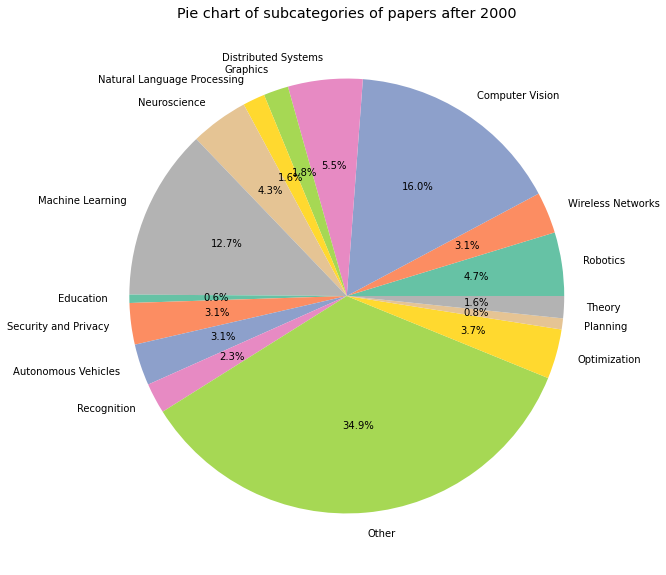

In [696]:
# Draw a pie chart with percentage of subcategories of all papers after 2000
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
sizes = []
cat_list = [x for catlst in df_cat["category"] for x in catlst]
for cat in unique_cate:
    sizes.append(cat_list.count(cat))

plt.pie(sizes, labels = unique_cate, autopct = '%1.1f%%', textprops={'fontsize': 10})
plt.title("Pie chart of subcategories of papers after 2000")
plt.show()

# Identify Ethnicity Patterns Over Time

In [505]:
def name_to_race(authors):
    """Map a list of authors to a list of their ethnicities"""
    ret_list = []
    for author in authors:
        try:
            race = race_dict[author]
            ret_list.append(race)
        except:
            print(author, ' has no race match.')
            continue
    return ret_list

In [512]:
race_dict = dict(zip(list(odf['author']), list(odf['race'])))
df_copy = df_export.copy()
df_race = df_copy.drop(columns = ['link', 'keyword', 'abstract'])
df_race['race'] = df['author'].apply(name_to_race)
df_race["white"] = df_race["race"].apply(lambda x: x.count("white"))
df_race["black"] = df_race["race"].apply(lambda x: x.count("black"))
df_race["hispanic"] = df_race["race"].apply(lambda x: x.count("hispanic"))
df_race["asian"] = df_race["race"].apply(lambda x: x.count("asian"))
df_race

,title,year,author,race,white,black,hispanic,asian
0,A Trainable System for Object Detection in Ima...,2000,"[Papageorgiou, Constantine P.]",[white],1,0,0,0
1,A Note on the Generalization Performance of Ke...,2000,"[Evgeniou, Theodoros, Pontil, Massimiliano]","[white, hispanic]",1,0,1,0
2,Experimental Markets for Product Concepts,2001,"[Chan, Nicholas T., Dahan, Ely, Lo, Andrew W.,...","[white, white, white, white]",4,0,0,0
3,How do Humans Determine Reflectance Properties...,2001,"[Fleming, Roland W., Dror, Ron O., Adelson, Ed...","[white, white, white]",3,0,0,0
4,Surface Reflectance Estimation and Natural Ill...,2001,"[Dror, Ron O., Adelson, Edward H., Willsky, Al...","[white, white, white]",3,0,0,0
5,Role of color in face recognition,2001,"[Yip, Andrew, Sinha, Pawan]","[asian, asian]",0,0,0,2
6,Multiclass Classification of SRBCTs,2001,"[Yeo, Gene, Poggio, Tomaso]","[white, white]",2,0,0,0
7,Range Segmentation Using Visibility Constraints,2001,"[Taycher, Leonid, Darrell, Trevor]","[white, white]",2,0,0,0
8,Type-omega DPLs,2001,"[Arkoudas, Konstantine]",[white],1,0,0,0
9,An Algorithm for Bootstrapping Communications,2001,"[Beal, Jacob]",[white],1,0,0,0


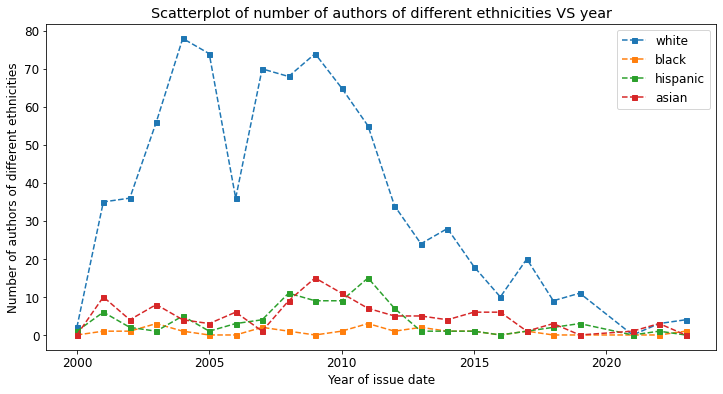

In [548]:
# Calculate number of authors of different ethnicities for each year
df_race_year = df_race.groupby(["year"]).agg({'white':['sum'], 'black':['sum'], 'hispanic':['sum'], 'asian':['sum']}).droplevel(axis=1, level=1)

# Draw a scatterplot of Number of authors of different ethnicities VS Year
plt.rcParams.update({'font.size': 12})
x = df_race_year.index
y1 = df_race_year["white"]
y2 = df_race_year["black"]
y3 = df_race_year["hispanic"]
y4 = df_race_year["asian"]
plt.figure(figsize=(12, 6))
plt.plot(x, y1, linestyle='dashed', marker='s', markersize = 5)
plt.plot(x, y2, linestyle='dashed', marker='s', markersize = 5)
plt.plot(x, y3, linestyle='dashed', marker='s', markersize = 5)
plt.plot(x, y4, linestyle='dashed', marker='s', markersize = 5)
plt.legend(['white', 'black', 'hispanic', 'asian'])
plt.xlabel("Year of issue date")
plt.ylabel("Number of authors of different ethnicities")
plt.title("Scatterplot of number of authors of different ethnicities VS year")
plt.show()

# Identify AI Subcategory Patterns Over Time

In [600]:
df

,title,year,keyword,abstract,category
0,A Trainable System for Object Detection in Ima...,2000,"[ai, mit, artificial intelligence, object dete...","This thesis presents a general, trainable sys...",[Computer Vision]
1,A Note on the Generalization Performance of Ke...,2000,"[ai, mit, artificial intelligence, missing dat...",We present distribution independent bounds on ...,[Machine Learning]
2,Experimental Markets for Product Concepts,2001,[ai],Market prices are well known to efficiently co...,[Other]
3,How do Humans Determine Reflectance Properties...,2001,"[ai, illumination, reflectance, natural image ...","Under normal viewing conditions, humans find i...","[Computer Vision, Graphics]"
4,Surface Reflectance Estimation and Natural Ill...,2001,"[ai, reflectance, lighting, brdf, surface, ill...",Humans recognize optical reflectance propertie...,"[Computer Vision, Graphics]"
5,Role of color in face recognition,2001,"[ai, face recognition, color, low-resolution, ...",One of the key challenges in face perception l...,[Recognition]
6,Multiclass Classification of SRBCTs,2001,"[ai, multiclass, svm, feature selection, srbct...",A novel approach to multiclass tumor classific...,[Machine Learning]
7,Range Segmentation Using Visibility Constraints,2001,[ai],Visibility constraints can aid the segmentatio...,[Other]
8,Type-omega DPLs,2001,"[ai, deduction, computation, proof search, sou...",Type-omega DPLs (Denotational Proof Languages)...,[Other]
9,An Algorithm for Bootstrapping Communications,2001,"[ai, adaptive learning hash-coding communicati...",I present an algorithm which allows two agents...,[Other]


In [620]:
# Create a copy of dataframe and add columns indicating number of subcategories of each paper
df_cat = df.copy()
df_cat = df_cat.drop(columns = ["keyword", "abstract", "title"])
unique_cate.sort()
df_cat[[unique_cate]] = None
for cat in unique_cate:
    df_cat[cat] = df["category"].apply(lambda x: x.count(cat))
df_cat = df_cat.drop(columns = ["category"])

# Calculate number of each subcategory of all papers over time
df_cat_year = df_cat.groupby(["year"]).agg(["sum"]).droplevel(axis=1, level=1)
df_cat_year.head(5)

,Autonomous Vehicles,Computer Vision,Distributed Systems,Education,Graphics,Machine Learning,Natural Language Processing,Neuroscience,Optimization,Other,Planning,Recognition,Robotics,Security and Privacy,Theory,Wireless Networks
year,,,,,,,,,,,,,,,,
2000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2001,0,11,0,0,2,4,0,0,0,10,0,2,0,0,0,0
2002,1,6,1,0,0,3,0,1,1,12,0,1,0,0,0,0
2003,0,9,2,0,2,11,1,2,0,16,0,4,4,0,0,3
2004,1,18,0,0,0,8,0,8,2,16,0,0,3,0,0,0


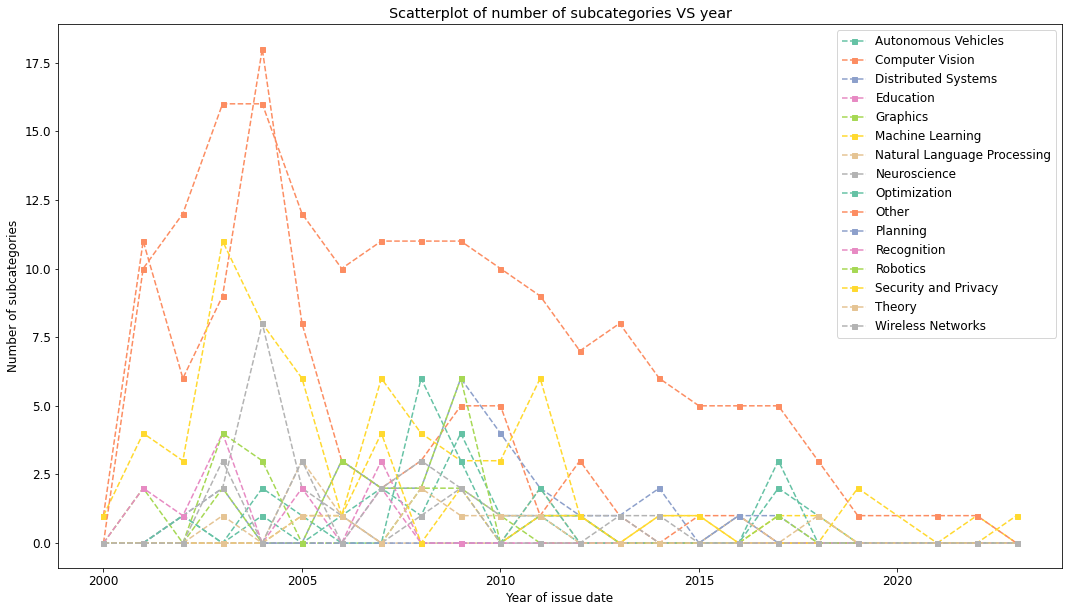

In [627]:
# Draw a scatterplot of Number of subcategories VS Year
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(18, 10))
sns.color_palette("Spectral", as_cmap=True)

x = df_cat_year.index
for cat in unique_cate:
    y = df_cat_year[cat]
#     plt.plot(x, y, linestyle='dashed', marker='s', markersize = 5)
    plt.hist(df['individuals'], bins=25, alpha=0.45, color='red')


plt.legend(unique_cate)
plt.xlabel("Year of issue date")
plt.ylabel("Number of subcategories")
plt.title("Scatterplot of number of subcategories VS year")
plt.show()

# Randomly Select Authors

In [421]:
# Randomly select 50 authors 
author_list = list(set(author_list))
authors_50 = random.sample(author_list, 50)
df_career = pd.DataFrame(data = {"Author": authors_50}).sort_values(by="Author").reset_index(drop=True)
df_career.to_excel("author.xlsx")

This section involved a sample of 50 authors who were randomly selected. From this initial group, 30 authors were further selected as they were found to be current faculty members of US top ranked universities, based on their LinkedIn pages and online CVs. Then I researched their career paths and relevant information such as the universities where they were employed, their professional positions outside of academia, and the year they began working in industry were recorded in an Excel spreadsheet.

In [685]:
# Import the excel file including detailed information of authors' career paths
df_car = pd.read_excel("authors_career.xlsx", engine="openpyxl")

# Count the number of authors who have engaged in activities outside of academia
nov_industry = df_car[df_car["Industry"].notna()].shape[0]
print(f"Out of the 30 authors who are currently faculty members at top-ranked universities in the United States, a total of {nov_industry} professors have been involved in activities beyond academia.")

Out of the 30 authors who are currently faculty members at top-ranked universities in the United States, a total of 15 professors have been involved in activities beyond academia.


In [687]:
# Extract data for authors who have worked in industry
df_ind = df_car[df_car["Industry"].notna()].reset_index(drop=True)
df_ind["Year"] = df_ind["Year"].astype(int)
df_ind

,Author,University,Industry,Year
0,"Adib, Fadel",MIT,CEO of Cartesian Systems,2022
1,"Andoni, Alexandr",Columbia,Scientist at Microsoft,2010
2,"Bouvrie, Jacob",Duke,Vice President of KAYAK-OpenTable,2019
3,"Chen, Jing",MIT,Chief Scientist at Algorand,2018
4,"Collins, Michael",Columbia,Researcher at AT&T,1999
5,"Das, Sanmay",George Mason University,Consultant at Bessemer Venture Partners,2004
6,"Eisenstein, Jacob",GIT,Research Scientist at Google,2019
7,"Eriksson, Jakob",UIC,Lead Developer at Use-IT Information AB,1999
8,"Grauman, Kristen",University of Texas at Austin,Research Scientist at Facebook AI Research (FAIR),2018
9,"Liang, Percy",Stanford,Researcher at Microsoft Semantic Machines,2016


In [772]:
df1 = df_cat.copy()
df_ind[["Before", "After"]] = None

for i in range(df_ind.shape[0]):
    author = df_ind.loc[i, "Author"]
    year_thr = df_ind.loc[i, "Year"]
    
    before = []
    after = []
    for j in range(df1.shape[0]):
        authors_lst = df1.loc[j, 'author']
        date_issued = df1.loc[j, 'year']
        keywords = df1.loc[j, "category"]

        # Check if author has written this paper
        if author in authors_lst:
            if date_issued < year_thr:
                before = before + keywords
            else:
                after = after + keywords
                
    df_ind.at[i, "Before"] = before
    df_ind.at[i, "After"] = after

df_ind

,Author,University,Industry,Year,Before,After
0,"Adib, Fadel",MIT,CEO of Cartesian Systems,2022,[Other],[]
1,"Andoni, Alexandr",Columbia,Scientist at Microsoft,2010,[Other],[]
2,"Bouvrie, Jacob",Duke,Vice President of KAYAK-OpenTable,2019,[Recognition],[]
3,"Chen, Jing",MIT,Chief Scientist at Algorand,2018,"[Optimization, Optimization, Optimization, Oth...",[]
4,"Collins, Michael",Columbia,Researcher at AT&T,1999,[],[Machine Learning]
5,"Das, Sanmay",George Mason University,Consultant at Bessemer Venture Partners,2004,[Other],[]
6,"Eisenstein, Jacob",GIT,Research Scientist at Google,2019,"[Robotics, Machine Learning, Robotics, Machine...",[]
7,"Eriksson, Jakob",UIC,Lead Developer at Use-IT Information AB,1999,[],[Other]
8,"Grauman, Kristen",University of Texas at Austin,Research Scientist at Facebook AI Research (FAIR),2018,"[Computer Vision, Computer Vision, Computer Vi...",[]
9,"Liang, Percy",Stanford,Researcher at Microsoft Semantic Machines,2016,[Other],[]


Using the dataframe containing information on 15 professors, it was found that none of them had published papers in MIT's Computer Science and Artificial Intelligence Lab both before and after their period of employment outside of academia from the pool of papers after 2000. To further explore this issue, the authors' works were searched on the Google Scholar website in order to obtain a larger sample size. Subsequently, the papers were categorized based mainly on their titles and abstracts, and relevant information was recorded in the dataframe presented below.

In [793]:
df_outacademia = pd.read_excel("careers_subcategories.xlsx", engine = "openpyxl").drop(columns = ["Unnamed: 0"])
df_outacademia

,Author,University,Industry,Year,Before,After
0,"Adib, Fadel",MIT,CEO of Cartesian Systems,2022,"['Autonomous Vehicles', 'Wireless Systems']",['Autonomous Vehicles']
1,"Andoni, Alexandr",Columbia,Scientist at Microsoft,2010,['Theory'],['Theory]
2,"Bouvrie, Jacob",Duke,Vice President of KAYAK-OpenTable,2019,"['Recognition', 'Machine Learning']",[]
3,"Chen, Jing",MIT,Chief Scientist at Algorand,2018,"['Optimization', 'Machine Learning', 'Quantum ...","['Optimization', 'Machine Learning']"
4,"Collins, Michael",Columbia,Researcher at AT&T,1999,"['Machine Learning', 'Natural Language Process...","['Machine Learning', 'Natural Language Process..."
5,"Das, Sanmay",George Mason University,Consultant at Bessemer Venture Partners,2004,"['Optimization', 'Machine Learning']","['Optimization', 'Machine Learning']"
6,"Eisenstein, Jacob",GIT,Research Scientist at Google,2019,"['Robotics', 'Machine Learning', 'Natural Lang...",['Natural Language Processing]
7,"Eriksson, Jakob",UIC,Lead Developer at Use-IT Information AB,1999,['Distributed Systems],['Distributed Systems]
8,"Grauman, Kristen",University of Texas at Austin,Research Scientist at Facebook AI Research (FAIR),2018,"['Computer Vision', 'Machine Learning']","['Computer Vision', 'Machine Learning']"
9,"Liang, Percy",Stanford,Researcher at Microsoft Semantic Machines,2016,"['Machine Learning', 'Natural Language Process...","['Machine Learning', 'Natural Language Process..."


Conclusion:
- Based on the presented dataframe, it is apparent that the research topics of all professors remain substantially relevant both before and after their involvement in activities outside of academia. The data indicates that 4 professors retained their research interests exactly as they were before, while 5 professors have reduced some of their previous research interests, and 2 have broadened their research scope. Therefore, it can be inferred that a majority of the professors maintain their focus on their established area of expertise, irrespective of their engagement in non-academic pursuits, while some choose to narrow their research focus or explore new directions over time.

Improvement:
- It is important to acknowledge that certain limitations still persist, which could benefit from further refinement. Notably, the sample size of authors being limited to 15 may compromise the generalizability of our findings. Therefore, the inclusion of a greater number of papers from diverse data sources, such as ResearchGate, may provide a more comprehensive and representative dataset. Moreover, the process of categorizing research topics solely based on paper titles or keywords could be enhanced to ensure greater efficiency and accuracy. The implementation of machine learning techniques to analyze abstracts of papers is a promising avenue for improving the precision of research topic categorization.

Data Sources:
- https://dspace.mit.edu/handle/1721.1/5458/browse?type=dateissued
- https://scholar.google.com.au/schhp?hl=en
- https://www.researchgate.net/